ResNet18, 34, 50, VIP, MVP, DINO

In [1]:
from pathlib import Path
import zarr
from tqdm import trange


import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from src.models.generate_embeddings import generate_embeddings

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


In [3]:
from src.models.encoders import models

**All Files Loading Info**


In [15]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path("/home/ubuntu/semrep")
# project_root = Path("/content/drive/MyDrive/17 – Research/sim-2-real-representation-learning") # Lars
data_path = project_root / "data" / "processed"
models_path = project_root / "models"

# Output path
output_path = project_root / "embeddings" / "encoders"
output_path.mkdir(exist_ok=True)

In [5]:
# Load the data
sim = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")

datasets = {"sim": sim, "real": real}

for name, dataset in datasets.items():
    imgs = dataset["color_image2"]
    labels = dataset["action/pos"]

    print(
        f"Loaded {len(dataset['episode_ends'])} trajectories containing {imgs.shape[0]} frames of {name} data"
    )

Loaded 50 trajectories containing 24131 frames of sim data
Loaded 50 trajectories containing 27699 frames of real data


In [6]:
sim.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='action', nodes=(Node(disabled=True,…

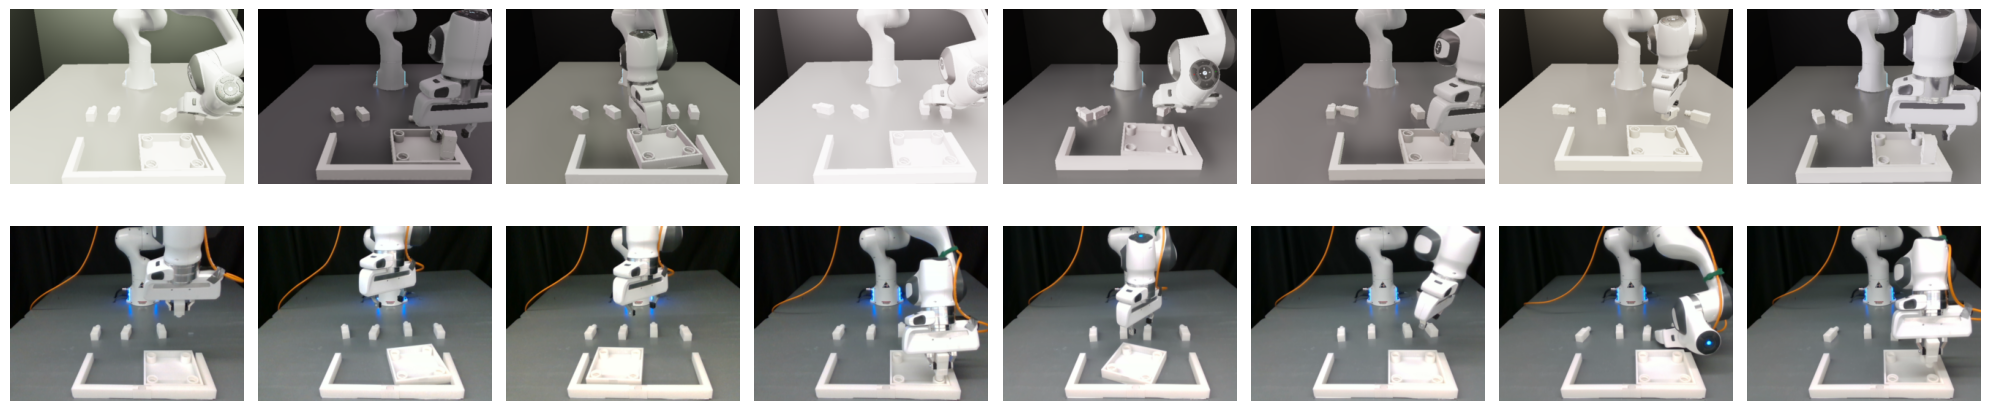

In [7]:
# Sample 8 images from each dataset
sim_indices = np.random.choice(datasets["sim"]["color_image2"].shape[0], size=8, replace=False)
real_indices = np.random.choice(datasets["real"]["color_image2"].shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

# Display the sampled images
for i, idx in enumerate(sim_indices):
    axes[0, i].imshow(datasets["sim"]["color_image2"][idx])
    axes[0, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[1, i].imshow(datasets["real"]["color_image2"][idx])
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [9]:
# Define resize transformation for MVP and VIP models

In [11]:
def process_dataset(m, dataset, dataset_type, num_samples=None, batch_size=1024):
    # Generate embeddings
    embeddings = generate_embeddings(
        m,
        dataset["color_image2"],
        num_samples=num_samples,
        batch_size=batch_size,
    ).numpy()

    # Make a split array for the embeddings into train and eval according to 90/10 split of trajectories
    split_index = dataset["episode_ends"][-5]

    # Split the embeddings into train and eval
    train_flag = np.zeros(embeddings.shape[0], dtype=bool)
    train_flag[:split_index] = True

    # Create a flag to indicate the dataset type (sim or real)
    dataset_flag = np.full(embeddings.shape[0], dataset_type, dtype=str)

    return embeddings, dataset["action/pos"], train_flag, dataset_flag

In [16]:
def process_all_models_and_datasets(models, datasets, device):
    results = {}

    print("Available models:", models.keys())

    for model_name, model_class in models.items():
        print(f"Processing with {model_name}")

        m: torch.nn.Module = model_class().to(device)

        # Process sim data
        sim_embeddings, sim_labels, sim_train_flag, sim_dataset_flag = process_dataset(
            m, datasets["sim"], "sim"
        )

        # Process real data
        real_embeddings, real_labels, real_train_flag, real_dataset_flag = process_dataset(
            m, datasets["real"], "real"
        )

        # Combine sim and real data
        combined_embeddings = np.vstack((sim_embeddings, real_embeddings))
        combined_labels = np.vstack((sim_labels, real_labels))
        combined_train_flag = np.concatenate((sim_train_flag, real_train_flag))
        combined_dataset_flag = np.concatenate((sim_dataset_flag, real_dataset_flag))

        # Store results for this model
        results = {
            "embeddings": combined_embeddings,
            "labels": combined_labels,
            "dataset_flag": combined_dataset_flag,
            "train_flag": combined_train_flag,
        }

        # Save the results
        output_file = output_path / f"{model_name}.npz"
        np.savez(
            output_file,
            **results,
        )

        print(f"Finished processing {model_name}")

    return results

In [17]:
# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_results = process_all_models_and_datasets(models, datasets, device)

Available models: dict_keys(['VIP', 'ResNet18', 'ResNet34', 'ResNet50', 'MVP', 'dinov2'])
Processing with VIP


/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/vip/__init__.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

Finished processing VIP
Processing with ResNet18


/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/r3m/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  r3m_state_dict = remove_language_head(torch.lo

Finished processing ResNet18
Processing with ResNet34


Processing: 100%|██████████| 28/28 [02:12<00:00,  4.73s/it]


Finished processing ResNet34
Processing with ResNet50


Processing: 100%|██████████| 28/28 [02:24<00:00,  5.17s/it]


Finished processing ResNet50
Processing with MVP


/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/mvp/backbones/vit.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f, map_location=

Loaded encoder from: /tmp/mvp-download-cache/vitb-mae-egosoup.pth


Processing: 100%|██████████| 28/28 [03:10<00:00,  6.79s/it]


Finished processing MVP
Processing with dinov2


Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 298MB/s]
Processing: 100%|██████████| 28/28 [02:32<00:00,  5.46s/it]

Finished processing dinov2


In [5]:
import numpy as np


def load_and_use_existing_split(file_path):
    # Load the NPZ file
    data = np.load(file_path)

    # Extract the arrays
    embeddings = data["embeddings"]
    labels = data["labels"]
    train_flag = data["train_flag"]
    dataset_flag = data["dataset_flag"]

    # Use the existing train_flag to split the data
    train_mask = train_flag == 1
    val_mask = train_flag == 0

    # Create the final splits
    train_data = {
        "embeddings": embeddings[train_mask],
        "labels": labels[train_mask],
        "dataset_flag": dataset_flag[train_mask],
    }

    val_data = {
        "embeddings": embeddings[val_mask],
        "labels": labels[val_mask],
        "dataset_flag": dataset_flag[val_mask],
    }

    return train_data, val_data

In [30]:
# Usage example
file_path = "/home/ubuntu/semrep/embeddings/encoders/dinov2.npz"

train_data, val_data = load_and_use_existing_split(file_path)

# Now you can access the train and validation data like this:
train_embeddings = train_data["embeddings"]
train_labels = train_data["labels"]
train_dataset_flag = train_data["dataset_flag"]

val_embeddings = val_data["embeddings"]
val_labels = val_data["labels"]
val_dataset_flag = val_data["dataset_flag"]

# Print some information about the splits
print(f"Training set size: {len(train_embeddings)}")
print(f"Validation set size: {len(val_embeddings)}")

# Check the distribution of sim vs real data in each split
print(
    f"Training set - Sim data: {np.sum(train_dataset_flag == 's')}, Real data: {np.sum(train_dataset_flag == 'r')}"
)
print(
    f"Validation set - Sim data: {np.sum(val_dataset_flag == 's')}, Real data: {np.sum(val_dataset_flag == 'r')}"
)

Training set size: 47432
Validation set size: 4398
Training set - Sim data: 22021, Real data: 25411
Validation set - Sim data: 2110, Real data: 2288


In [31]:
from src.models.tsne import plot_tsne

In [32]:
dataset = np.load(file_path)

dataset.keys()

KeysView(NpzFile '/home/ubuntu/semrep/embeddings/encoders/dinov2.npz' with keys: embeddings, labels, train_flag, dataset_flag)

In [33]:
embeddings = dataset["embeddings"]

In [19]:
plot_tsne(
    embeddings=embeddings,
    dataset_flags=dataset["dataset_flag"],
)

/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 

In [34]:
def domain_r_squared(embeddings, dataset_flags):
    # Create masks for sim and real data
    sim_mask = dataset_flags == "s"
    real_mask = dataset_flags == "r"
    sim_embeddings = embeddings[sim_mask].flatten()
    real_embeddings = embeddings[real_mask].flatten()

    length = sim_embeddings.shape[0] 
    print(length)

    real_embeddings = real_embeddings[:length]

    correlation_matrix = np.corrcoef(sim_embeddings, real_embeddings)
    correlation_coefficient = correlation_matrix[0, 1]

    # Calculate R^2 value
    r_squared = correlation_coefficient ** 2

    print(f"R^2 value: {r_squared}")


domain_r_squared(embeddings, dataset["dataset_flag"])

9266304
R^2 value: 0.5447772436828339
